In [1]:
import pandas as pd
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams

import nbconvert
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from IPython.display import Markdown, SVG, display, Image, HTML

from config import *
# Downloaded the stopwords through nltk
#nltk.download('stopwords')
#nltk.download('punkt')

# Defintion to churn out totals/percentages to avoid copy pasta.
def summarize_column(df, column_name):
    non_null_data = df[column_name].dropna()
    summary = non_null_data.value_counts()
    percentages = (non_null_data.value_counts(normalize=True) * 100).round(1)
    summary = pd.DataFrame({'Total': summary, 'Percentage': percentages})
    sample_size = non_null_data.shape[0]
    return summary, sample_size

<div style="text-align: center;">

<h1>Yarn Survey 2024</h1>

<h4>Presented by</h4>

<h2>Premier Needle Arts</h2>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    The 2024 Yarn Survey was put on by Knit Picks, Berroco, and Crochet.com <br> to get more contextual knowledge of knitters, crocheters, and general yarn enthusiasts.
</div>

In [2]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')

In [3]:
# Create list of all questions to summarize.
[(i, col) for i, col in enumerate(all_responses.columns.tolist())]

[(0, '#'),
 (1, 'First name'),
 (2, 'Email'),
 (3, 'Do you participate in any yarn crafts?'),
 (4, 'Do you crochet?'),
 (5, 'What is your current skill level in crocheting?'),
 (6, 'How often do you crochet?'),
 (7, 'Do you knit?'),
 (8, 'What is your current skill level in knitting?'),
 (9, 'How often do you knit?'),
 (10, 'Do you participate in yarn crafts besides crochet or knitting?'),
 (11, 'Which yarn craft do you participate in?'),
 (12, 'What is your current skill level in this yarn craft?'),
 (13, 'How often do you you participate in this yarn craft?'),
 (14, 'How do you most often purchase *yarn*?'),
 (15, 'Where do you most often purchase* yarn*?'),
 (16, 'How do you most often purchase yarn *tools & accessories*?'),
 (17, 'Where do you most often purchase *tools & accessories*?'),
 (18, 'How do you most often purchase *patterns*?'),
 (19, 'Where do you most often purchase *patterns*?'),
 (20, 'How have your yarn shopping habits changed over time?'),
 (21,
  'How many times 

## Demographic Summary

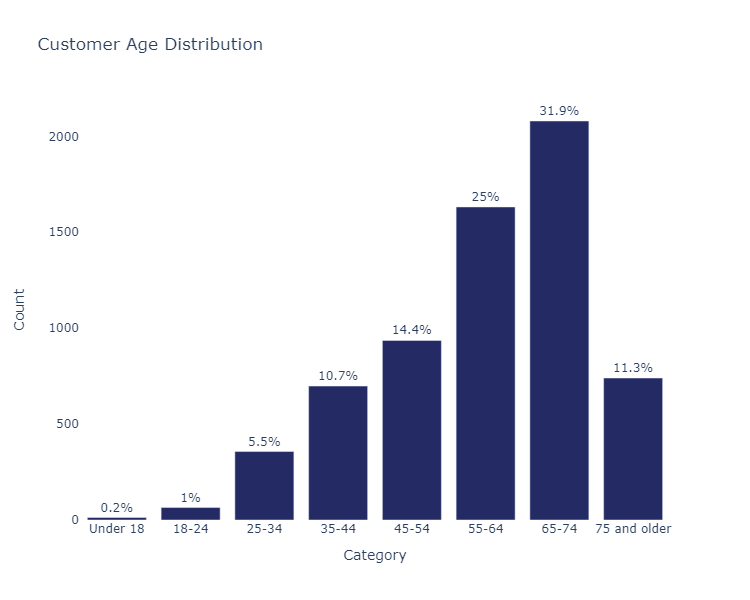

 - Out of **6521** respondants, the average respondant age is: **58** and the median age is: **59**.

- Of these respondants, they identify as:
    - "Woman" (98%)
    - "Non-Conforming / Non-Binary" (1%)
    - "Man" (1%)
    - "Transgender" (0%)


- The average household income is: **\$89,596** and the median household income is: **\$72,499** (From 4527 responses).
  - For ages **Under 18** the average household income is **\\$22,500**, the median household income is **\\$20,000** (From 3 responses.)
  - For ages **18-24** the average household income is **\\$61,250**, the median household income is **\\$42,500** (From 40 responses.)
  - For ages **25-34** the average household income is **\\$87,831**, the median household income is **\\$72,500** (From 287 responses.)
  - For ages **35-44** the average household income is **\\$102,103**, the median household income is **\\$90,000** (From 517 responses.)
  - For ages **45-54** the average household income is **\\$105,719**, the median household income is **\\$112,500** (From 594 responses.)
  - For ages **55-64** the average household income is **\\$97,537**, the median household income is **\\$90,000** (From 997 responses.)
  - For ages **65-74** the average household income is **\\$79,221**, the median household income is **\\$72,500** (From 1185 responses.)
  - For ages **75 and older** the average household income is **\\$74,103**, the median household income is **\\$57,500** (From 393 responses.)


In [4]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[76]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=750,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondants, the average respondant age is: **{average_age}** and the median age is: **{median_age}**."))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[77]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = "- Of these respondants, they identify as:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

### Income Section ###

# Income Question
question = all_responses.columns[81]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()

# Define the function to map income ranges to their midpoints
def map_income_to_midpoint(value):
    if value == 'Under $20,000':
        return 20000
    elif value == '$20,000 - $34,999':
        return (20000 + 34999) / 2
    elif value == '$35,000 - $49,999':
        return (35000 + 49999) / 2
    elif value == '$50,000 - $64,999':
        return (50000 + 64999) / 2
    elif value == '$65,000 - $79,999':
        return (65000 + 79999) / 2
    elif value == '$80,000 - $99,999':
        return (80000 + 99999) / 2
    elif value == '$100,000 - $124,999':
        return (100000 + 124999) / 2
    elif value == '$125,000 - $149,999':
        return (125000 + 149999) / 2
    elif value == '$150,000 - $174,999':
        return (150000 + 174999) / 2
    elif value == '$175,000 - $199,999':
        return (175000 + 199999) / 2
    elif value == 'Over $200,000':
        return 200000
    else:
        return np.nan

# Apply the function to the column data
income_data = column_data.map(map_income_to_midpoint)
# Calculate the average income
average_income = income_data.mean().astype(int)
# Calculate the median income
median_income = income_data.median().astype(int)
# Total count of responses
total_responses = income_data.dropna().count()
# Format the average and median income for readability with $ and commas
formatted_average_income = "\${:,.0f}".format(average_income)
formatted_median_income = "\${:,.0f}".format(median_income)

## Break down by age group. ##

age_question = all_responses.columns[76]

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[age_question] != 'Prefer not to answer') & 
                                        (all_responses[question] != 'Prefer not to answer')]

# Apply categorization and mapping for income midpoint again if necessary
filtered_responses['income_midpoint'] = filtered_responses[question].map(map_income_to_midpoint)
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[76]], categories=categories, ordered=True)

# Now group by the 'age_range' with the specified order
statistics = filtered_responses.groupby('age_range', observed=True)['income_midpoint'].agg(['mean', 'median', 'count']).dropna()

# First part of the markdown about average and median income
markdown_part1 = f"- The average household income is: **{formatted_average_income}** and the median household income is: **{formatted_median_income}** (From {total_responses} responses)."

# Generating the second part with the breakdown by age group
markdown_part2 = ""
for age, row in statistics.iterrows():
    avg_income = "\${:,.0f}".format(row['mean'])
    median_income = "\${:,.0f}".format(row['median'])
    responses = row['count'].astype(int)
    markdown_part2 += f"  - For ages **{age}** the average household income is **\{avg_income}**, the median household income is **\{median_income}** (From {responses} responses.)\n"

# Combine the two parts into a single Markdown display, with the second part indented as a sub-list
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

In [5]:
#%%capture
# !jupyter nbconvert --to webpdf Yarn_survey.ipynb --output All_PDF_Export --output-dir ./PDF --no-input

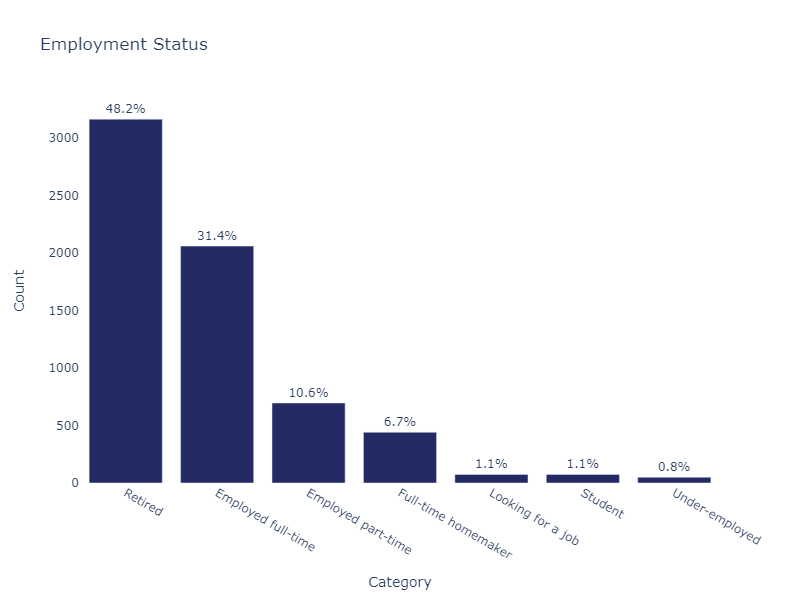

- Of the respondents, their employment statuses are as follows:
    - "Retired" (48%)
    - "Employed full-time" (31%)
    - "Employed part-time" (11%)
    - "Full-time homemaker" (7%)
    - "Looking for a job" (1%)
    - "Student" (1%)
    - "Under-employed" (1%)


In [6]:
### Employment ###
question = all_responses.columns[78]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = "- Of the respondents, their employment statuses are as follows:\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - \"{key}\" ({round(value)}%)\n"

display(Markdown(markdown_text))

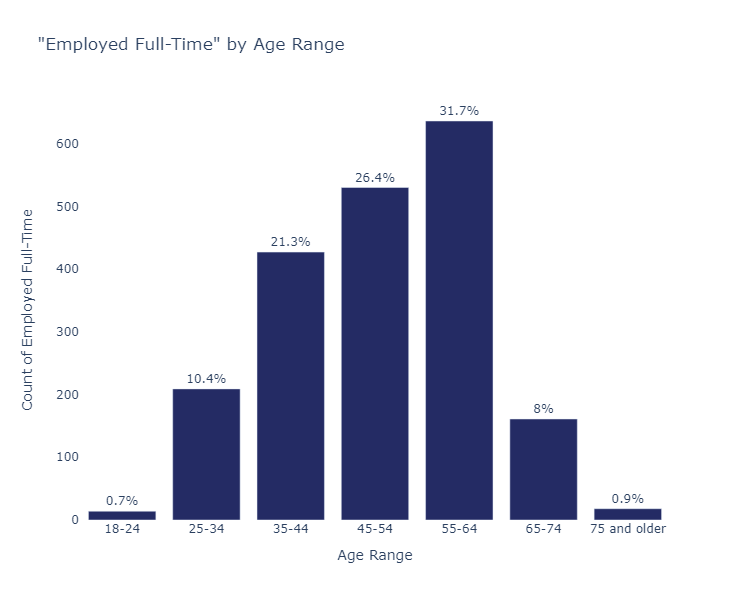

- Of those who responded 'Employed Full-Time', their age ranges are as follows:
    - "55-64" (31.7%)
    - "45-54" (26.4%)
    - "35-44" (21.3%)
    - "25-34" (10.4%)
    - "65-74" (8.0%)
    - "75 and older" (0.9%)
    - "18-24" (0.7%)


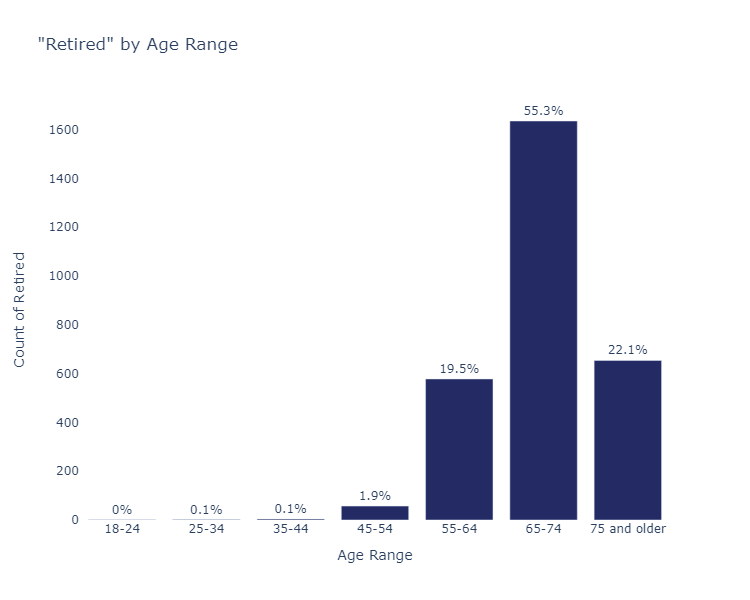

- Of those who responded 'Retired', their age ranges are as follows:
    - "65-74" (55.3%)
    - "75 and older" (22.1%)
    - "55-64" (19.5%)
    - "45-54" (1.9%)
    - "25-34" (0.1%)
    - "35-44" (0.1%)
    - "18-24" (0.0%)


In [7]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[76]
employment_status_column = all_responses.columns[78]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = "- Of those who responded 'Employed Full-Time', their age ranges are as follows:\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    margin=dict(t=100)
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = "- Of those who responded 'Retired', their age ranges are as follows:\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - \"{age_group}\" ({percentage}%)\n"

display(Markdown(markdown_text))


In [35]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24]]]], axis=1)

# Apply assign_count to first and third columns
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))


# Apply assign_middle_price to second and fourth columns
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))



In [36]:
share_of_wallet.iloc[:, 0]

0       NaN
1        10
2         1
3         5
4         5
       ... 
7553      2
7554      3
7555    NaN
7556      6
7557      1
Name: How many times do you make an *in-store* yarn related purchase each year?, Length: 7558, dtype: object

In [37]:
print(share_of_wallet.iloc[:, 0].astype(float).mean())

4.699985014236475


In [ ]:
# Question
question = all_responses.columns[4]
column_data = all_responses[question].dropna()
sample_size = column_data.shape[0]
display(Markdown(f"### Question: {question} *(N = {sample_size})*"))
print("\n")

# Calculate number of responses/percentages using column_data
counts = column_data.value_counts()
percentages = column_data.value_counts(normalize=True).mul(100).round(1)

# Create DataFrame with the results
summary_df = pd.DataFrame({'Answer': counts.index, 'Responses': counts.values, 'Percentage': percentages.values})

# Create Plotly table
table = ff.create_table(summary_df)
table.update_layout(width=600)
table.show()


In [ ]:
print("\n" * 4)

In [ ]:
# Question
question = all_responses.columns[5]
column_data = all_responses[question].dropna()
sample_size = column_data.shape[0]
display(Markdown(f"### Question: {question} *(N = {sample_size})*"))
print("\n")

# Calculate number of responses/percentages using column_data
counts = column_data.value_counts()
percentages = column_data.value_counts(normalize=True).mul(100).round(1)

# Create DataFrame with the results
summary_df = pd.DataFrame({'Answer': counts.index, 'Responses': counts.values, 'Percentage': percentages.values})

# Create Plotly table
table = ff.create_table(summary_df)
table.update_layout(width=600)
table.show()


In [ ]:
print("\n" * 4)

In [ ]:
# How often do you crochet?
question = all_responses.columns[6]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Do you knit?
question = all_responses.columns[7]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# What is your current skill level in knitting?
question = all_responses.columns[8]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How often do you knit?
question = all_responses.columns[9]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Do you participate in yarn crafts besides crochet or knitting?
question = all_responses.columns[10]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Which yarn craft do you participate in?

# Case sensitive, cast lower case. 
all_responses.iloc[:, 11] = all_responses.iloc[:, 11].str.lower()
# Reset null values.
all_responses.iloc[:, 11] = all_responses.iloc[:, 11].astype(str).str.lower().replace('nan', np.nan)

# Do you participate in yarn crafts besides crochet or knitting?
question = all_responses.columns[11]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your current skill level in this yarn craft?	
question = all_responses.columns[12]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How often do you you participate in this yarn craft?
question = all_responses.columns[13]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How do you most often purchase *yarn*?	
question = all_responses.columns[14]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(2))

In [ ]:
print("\n" * 4)

In [ ]:
# Where do you most often purchase* yarn*?	
question = all_responses.columns[15]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(7))

In [ ]:
print("\n" * 4)

In [ ]:
# How do you most often purchase yarn *tools & accessories*?
question = all_responses.columns[16]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(2))

In [ ]:
print("\n" * 4)

In [ ]:
# Where do you most often purchase *tools & accessories*?
question = all_responses.columns[17]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(7))

In [ ]:
print("\n" * 4)

In [ ]:
# How do you most often purchase *patterns*?
question = all_responses.columns[18]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(2))

In [ ]:
print("\n" * 4)

In [ ]:
# Where do you most often purchase *patterns*?
question = all_responses.columns[19]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(6))

In [ ]:
print("\n" * 4)

In [ ]:
# How have your yarn shopping habits changed over time?
question = all_responses.columns[20]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How many times do you make an *in-store* yarn related purchase each year?
question = all_responses.columns[21]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How much do you typically spend per *in-store* purchase?
question = all_responses.columns[22]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How many times do you make an *online* yarn related purchase each year?
question = all_responses.columns[23]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How much do you typically spend per *online* purchase?
question = all_responses.columns[24]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Where did you receive this survey from?
question = all_responses.columns[25]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# How did you first hear about our brand?
question = all_responses.columns[26]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(6))

In [ ]:
print("\n" * 4)

In [ ]:
# How did you first hear about our brand?
question = all_responses.columns[27]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(8))

In [ ]:
print("\n" * 4)

In [ ]:
# Which brands have you heard of?

# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

print(f'Question: {question} (Sample Size: n = {sample_size})')

display(brand_counts)  

In [ ]:
print("\n" * 4)

In [ ]:
# Which brands have you purchase from?

# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

print(f'Question: {question} (Sample Size: n = {sample_size})')

display(brand_counts)  

In [ ]:
print("\n" * 4)

In [ ]:
# What makes our yarn stand out from competitors to you?

# Print statement question.
question = all_responses.columns[30]
#Same size.
sample_size = all_responses.iloc[:, 30].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 30].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Add a line break
print("\n")

print("Top 10 Bi-grams:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Tri-grams:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
# Compared to other brands, how do you rate the price of our products?
question = all_responses.columns[31]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Where do you prefer to explore or learn about new yarn products?
question = all_responses.columns[32]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Which social media platform do you prefer to learn about new yarn products?
question = all_responses.columns[33]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(8))

In [ ]:
print("\n" * 4)

In [ ]:
# When shopping online, what encourages you to try *new* yarn products?
question = all_responses.columns[34]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(6))

In [ ]:
print("\n" * 4)

In [ ]:
# What products do you primarily associate with our brand?

# Print statement question.
question = all_responses.columns[35]
#Same size.
sample_size = all_responses.iloc[:, 35].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 35].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Add a line break
print("\n")

print("Top 10 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Three Word Occurrences:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
#  Which of our yarn fibers do you frequently purchase?

# Print statement question.
question = all_responses.columns[36]

# Remove parenthesis, they have commas.
preprocessed = all_responses.iloc[:, 36].str.replace(r"\s*\([^)]*\)", "", regex=True)

# Split previous concatenation.
split_options = preprocessed.str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 36].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'Split': split_options})
temp_df = temp_df.explode('Split')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['Split'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
option_counts = temp_df['Split'].value_counts().reset_index()
option_counts.columns = ['Options', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
option_counts['Percentage'] = ((option_counts['Count'] / sample_size) * 100).round(1)

print(f'Question: {question} (Sample Size: n = {sample_size})')

display(option_counts.head(5))  

In [ ]:
print("\n" * 4)

In [ ]:
# Which types of projects do you typically buy our yarn for?

# Print statement question.
question = all_responses.columns[37]

# Remove parenthesis, they have commas.
preprocessed = all_responses.iloc[:, 37].str.replace(r"\s*\([^)]*\)", "", regex=True)

# Split previous concatenation.
split_options = preprocessed.str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 37].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'Split': split_options})
temp_df = temp_df.explode('Split')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['Split'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
option_counts = temp_df['Split'].value_counts().reset_index()
option_counts.columns = ['Options', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
option_counts['Percentage'] = ((option_counts['Count'] / sample_size) * 100).round(1)

print(f'Question: {question} (Sample Size: n = {sample_size})')

display(option_counts.head(5))  

In [ ]:
print("\n" * 4)

In [ ]:
# Can you briefly explain why you buy these yarn fibers for the selected project types?

# Print statement question.
question = all_responses.columns[38]
#Same size.
sample_size = all_responses.iloc[:, 38].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 38].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Line break
print("\n")

print("Top 10 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Three Word Occurrences:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
# How important is sustainability in the yarns you choose?
question = all_responses.columns[39]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)

In [ ]:
print("\n" * 4)

In [ ]:
# Which social media platforms do you normally get project ideas from?

# Print statement question.
question = all_responses.columns[40]

# Remove parenthesis, they have commas.
preprocessed = all_responses.iloc[:, 40].str.replace(r"\s*\([^)]*\)", "", regex=True)

# Split previous concatenation.
split_options = preprocessed.str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 40].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'Split': split_options})
temp_df = temp_df.explode('Split')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['Split'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
option_counts = temp_df['Split'].value_counts().reset_index()
option_counts.columns = ['Options', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
option_counts['Percentage'] = ((option_counts['Count'] / sample_size) * 100).round(1)

print(f'Question: {question} (Sample Size: n = {sample_size})')

display(option_counts.head(10)) 

In [ ]:
print("\n" * 4)

In [ ]:
# Who is your favorite content creator or designer you follow?

# Print statement question.
question = all_responses.columns[41]
#Same size.
sample_size = all_responses.iloc[:, 41].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 41].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)

# Count and find the top 10 uni, bi, and tri-grams,
top_bi_grams = Counter(bi_grams).most_common(20)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

print("Top 20 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")


In [ ]:
print("\n" * 4)

In [ ]:
# How many projects do you start in a year?
question = all_responses.columns[42]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How many projects do you complete in a year?
question = all_responses.columns[43]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How do you feel about the balance between classic and trendy yarns in our selection? 1 Classic , 5 Trendy.
question = all_responses.columns[44]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How often is something you want from our website out-of-stock?
question = all_responses.columns[45]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How effective is our communication when items are restocked?
question = all_responses.columns[46]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Have you been able to find everything you need for a project on our website?
question = all_responses.columns[47]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Are there any yarn related products you think we should start carrying?

# Print statement question.
question = all_responses.columns[48]
#Same size.
sample_size = all_responses.iloc[:, 48].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 48].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Line break
print("\n")

print("Top 10 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Three Word Occurrences:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
# How easy do you find navigating our website to browse products?
question = all_responses.columns[49]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Would you recommend any changes to our website to make browsing easier?

# Print statement question.
question = all_responses.columns[50]
#Same size.
sample_size = all_responses.iloc[:, 50].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 50].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Line break
print("\n")

print("Top 10 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Three Word Occurrences:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
# How would you rate the organization and categorization of products on our site?
question = all_responses.columns[51]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Do you prefer broader categories with more products or more specific categories with fewer products?
question = all_responses.columns[52]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Have you received one of our catalogs before?
question = all_responses.columns[53]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Do you enjoy receiving our product catalogs?
question = all_responses.columns[54]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How often do our catalogs introduce you to products you weren't aware of before?
question = all_responses.columns[55]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Have you ever made a purchase after seeing a product in our catalog?
question = all_responses.columns[56]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Are you concerned about the environmental impact of receiving physical catalogs?
question = all_responses.columns[57]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# Do you prefer receiving our catalogs digitally or in a physical format? 
question = all_responses.columns[58]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What improvements would you suggest for our future catalogs?

# Print statement question.
question = all_responses.columns[59]
#Same size.
sample_size = all_responses.iloc[:, 59].notnull().sum()

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

#Case sensitive, cast lower case. 
process_data = all_responses.iloc[:, 59].dropna().astype(str).str.lower()  # Lowercase conversion

def clean_text(text):
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply cleaning function
tokenized_data = process_data.apply(clean_text)

# Apply stemming
stemmed_data = tokenized_data.apply(lambda x: [stemmer.stem(word) for word in x])

# Flatten the list of lists for n-grams analysis
all_words = [word for text in stemmed_data for word in text]

# Generate bi-grams and tri-grams
bi_grams = ngrams(all_words, 2)
tri_grams = ngrams(all_words, 3)

# Count and find the top 10 uni, bi, and tri-grams,
top_unigrams = Counter(all_words).most_common(10)
top_bi_grams = Counter(bi_grams).most_common(10)
top_tri_grams = Counter(tri_grams).most_common(10)

#Question statement
print(f'Question: {question} (Sample Size: n = {sample_size})')

# Line break
print("\n")

# Print the top 10 single word occurrences
print("Top 10 Single Word Occurrences:")
for word, count in top_unigrams:
    print(f"{word}: {count}")

# Line break
print("\n")

print("Top 10 Two Word Occurrences:")
for gram, count in top_bi_grams:
    print(f"{gram}: {count}")

# Add a line break
print("\n")

print("\nTop 10 Three Word Occurrences:")
for gram, count in top_tri_grams:
    print(f"{gram}: {count}")

In [ ]:
print("\n" * 4)

In [ ]:
# Have you ever contacted our customer service before? 
question = all_responses.columns[60]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# How would you rate the speed of our response to inquiries or issues?
question = all_responses.columns[61]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# How helpful do you find our customer service team?
question = all_responses.columns[62]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# How well did our customer service team understand the products related to your inquiry?
question = all_responses.columns[63]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# Overall, are you satisfied with the resolution our customer service provided?
question = all_responses.columns[64]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# What is one thing we could improve about our customer service?
question = all_responses.columns[65]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(5))

In [ ]:
print("\n" * 4)

In [ ]:
# On a scale of 0-10, how likely are you to recommend us to a friend or family member?
question = all_responses.columns[66]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your current age?
question = all_responses.columns[67]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# How do you identify? 
question = all_responses.columns[68]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your employment status?
question = all_responses.columns[69]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your highest level of education? 
question = all_responses.columns[70]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your marital status?
question = all_responses.columns[71]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary.head(10))

In [ ]:
print("\n" * 4)

In [ ]:
# What is your total household income in U.S. dollars?
question = all_responses.columns[72]
summary, sample_size = summarize_column(all_responses, question)

print(f'Question: {question} (Sample Size: n = {sample_size})')
display(summary)